<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Objective" data-toc-modified-id="Objective-1">Objective</a></span></li><li><span><a href="#About-Food-101" data-toc-modified-id="About-Food-101-2">About Food-101</a></span></li><li><span><a href="#Train-valid-split" data-toc-modified-id="Train-valid-split-3">Train-valid-split</a></span></li><li><span><a href="#Load-Food-101-Dataset" data-toc-modified-id="Load-Food-101-Dataset-4">Load Food-101 Dataset</a></span></li><li><span><a href="#Data-Augmentation" data-toc-modified-id="Data-Augmentation-5">Data Augmentation</a></span></li><li><span><a href="#First-Crack-at-a-Better-Model" data-toc-modified-id="First-Crack-at-a-Better-Model-6">First Crack at a Better Model</a></span><ul class="toc-item"><li><span><a href="#Label-Smoothing" data-toc-modified-id="Label-Smoothing-6.1">Label Smoothing</a></span></li></ul></li></ul></div>

In [3]:
import numpy as np
import torch

from pathlib import Path
from fastai2.vision.all import *
from fastai2.vision.widgets import *

In [4]:
# Set seed for reproducibility
seed = 9
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
# Although we don't condone it, let's silence warnings for the sake of readability
import warnings
warnings.filterwarnings("ignore")

---------

# Objective

The goal of this notebook is to train an image classifier on the full [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101) using the `fastai2` library. We'll be implementing progressize resizing with label smoothing.

--------

# About Food-101

The [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) consists of 101 classes of food, with $750$ training images and $250$ validation images in each class, for a total of $75,750$ training images and $25,250$ validation images. Classes include foods like `apple pie, bibimbap, crab cakes, gyoza, nachos, and pho`.

All images have been rescaled to have a maximum side length of $512$ pixels and training images have been deliberately left uncleaned (mostly in the form of intense colours and occassionally incorrect labels, according to the authors of the [original paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)). Examining a few images from a handful of classes, we find that $512$ x $384$ (or the transpose) is a common image size. We also find that a non-trivial amount of labels are shockingly incorrect. For example, one of the images labeled "french toast" is an image of an omelette.

-----

# Train-valid-split

We've split the `Food-101` dataset beforehand into Imagenet-style `train/` and `valid/` folders following the `train.txt` and `test.txt` files provided in the dataset's `meta/` directory. This makes loading the data easier as with fastai.

--------

# Load Food-101 Dataset

Let's load and prep our dataset for modeling.

In [6]:
# Prep DataBlock with item & batch transforms
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))

# Load data
path = Path("./drive/My Drive/Food-101/dataset")
dls = dblock.dataloaders(path, bs=64)

In [7]:
# Verify number of classes and images
print(dls.train.c, dls.train.n) 
print(dls.valid.c, dls.valid.n)

101 75750
101 25250


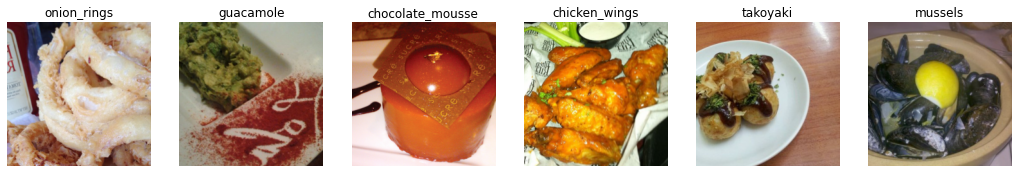

In [8]:
# Inspect data. Yum! Looks good to me!
dls.show_batch(nrows=1, ncols=6)

# Data Augmentation

When we initalised our `DataBlock` above, we had to specify what types of transforms we wanted to use to augument our data. We used the standard transforms specified in `aug_transforms`. By specifying `min_scale=0.75`, we also enabled `RandomResizeCrop`, which is performed on the fly on each batch on the gpu (hence won't be shown below). Let's take a closer look at these transforms before we move on. 

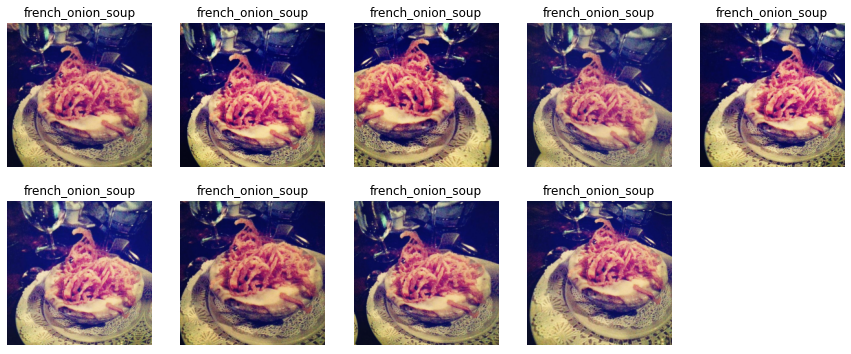

In [9]:
# Original plus eight augmentations for brightness/contrast, rotation, and a flip about x=0
dls.show_batch(nrows=2, unique=True)

---------

# First Crack at a Better Model

Now that we have a solid baseline model, it's time to experiment and see if we can't do a little better! We'll experiment with `Label Smoothing`.

## Label Smoothing

Our classifier is trained to return a probaility of `1.0` for the correct class and `0.0` for all other classes. However, it can never in fact predict `1.0` on the nose. This means that even a model that predicts the correct class with `0.999` probability will still affect the loss and hence the gradients. In other words, our model will continue to minimize the loss by becoming more and more confident in its predictions even when it's correct, because that's what it's trained to do.

Label smoothing tempers our model's confidence by changing the labels of our data from `(0, 1)` to something like `(0.1, 0.9)`. This makes it possible for a model to achieve zero loss on a specific training example, meaning that the training example will no longer affect the loss and gradients, which helps mitigate overfitting. The final loss will almost always be higher compared with using normal cross entropy because our model's predictions are bounded to the region to the interval `(0.1, 0.9)`. In practice, label smoothing requires more epochs to train but often improves a model's ability to generalize.

Because we had such tremendous success with progressive re-sizing, we'll implement label smoothing alongside it. Since our loss function is slightly different, we'll first need to find a good base learning rate.

In [13]:
def get_dls(path, bs, size):
    """Return a set of train and valid dataloaders with images of a given size."""
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                  get_items=get_image_files,
                  get_y=parent_label,
                  splitter=GrandparentSplitter(),
                  item_tfms=Resize(460),
                  batch_tfms=aug_transforms(size=size, min_scale=0.75))
    return dblock.dataloaders(path, bs=bs)

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.004365158267319202)

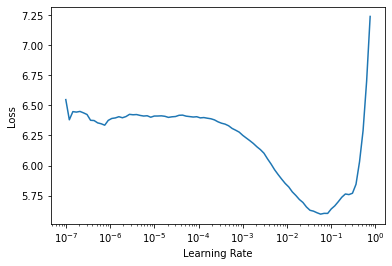

In [10]:
# First find a good learning rate
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.lr_find()

In [11]:
# Train on images of size 128
dls = get_dls(path, bs=128, size=128)
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fine_tune(3, 6e-3, freeze_epochs=2)
learn.save("colab-resnet50-smooth-128")

epoch,train_loss,valid_loss,accuracy,time
0,3.072128,2.488827,0.497069,11:15
1,2.593611,2.163795,0.589030,11:05


epoch,train_loss,valid_loss,accuracy,time
0,2.279292,1.990206,0.635366,11:18
1,1.915337,1.647210,0.737426,11:16
2,1.627801,1.490878,0.785822,11:17


In [12]:
# Bump image size to 224
learn.dls = get_dls(path, bs=64, size=224)
learn.fine_tune(7, 2e-3)
learn.save("colab-resnet50-smooth-128-224")

epoch,train_loss,valid_loss,accuracy,time
0,1.603150,1.382360,0.825149,12:04


epoch,train_loss,valid_loss,accuracy,time
0,1.542224,1.346435,0.833267,12:28
1,1.549866,1.373129,0.824515,12:31
2,1.488547,1.331767,0.837465,12:30
3,1.365629,1.298617,0.845386,12:32
4,1.245753,1.251241,0.859881,12:32
5,1.149546,1.226842,0.867089,12:32
6,1.121099,1.224790,0.868475,12:24


In [11]:
# Re-load previous model
learn = cnn_learner(dls, resnet50, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.load("colab-resnet50-smooth-128-224")

In [14]:
# Bump to the max image dim in our dataset
learn.dls = get_dls(path, bs=24, size=512)
learn.fine_tune(10, 1e-3)
learn.save("colab-resnet50-smooth-128-224-512")

epoch,train_loss,valid_loss,accuracy,time
0,1.495292,1.315563,0.848475,1:15:16


epoch,train_loss,valid_loss,accuracy,time
0,1.441789,1.260639,0.864554,36:36
1,1.415535,1.275528,0.858416,36:34
2,1.406655,1.270677,0.860673,36:33
3,1.402217,1.249132,0.868713,36:34
4,1.298407,1.227868,0.874535,36:40
5,1.241724,1.212503,0.877465,36:43
6,1.136449,1.183000,0.886970,36:44
7,1.101029,1.174963,0.890574,36:44
8,1.037576,1.165283,0.893149,36:45
9,1.031225,1.163489,0.894139,36:44


In [15]:
preds, targets = learn.tta()
top_1 = accuracy(preds, targets).item()
top_2 = top_k_accuracy(preds, targets, k=2).item()
print(f"Top-1 Accuracy: {top_1: .4f} | Top-2 Accuracy {top_2: .4f}")

Top-1 Accuracy:  0.8984 | Top-2 Accuracy  0.9519


Great! We're seeing a higher final validation accuracy at the end of the last cycle than we did on our baseline progressive model.